# Deep Q-learning or Q-network (DQN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return actions, states, targetQs, is_training

In [9]:
def init_xavier(random_seed=1, dtype=tf.float32, uniform=False):
    xavier = tf.contrib.layers.xavier_initializer(
        dtype=dtype,
        seed=tf.set_random_seed(random_seed), 
        uniform=uniform) # False: normal
    return xavier

In [10]:
def mlp(inputs, units, trainable=True):
    outputs = tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(), # Xavier with normal init
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)
    return outputs

In [11]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None
# )
def nl(inputs, alpha=0.2):
    outputs = tf.maximum(alpha * inputs, inputs)
    return outputs

In [12]:
def bn(inputs, training=False):
    outputs = tf.layers.batch_normalization(
        inputs=inputs,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training,
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)
    return outputs

In [13]:
# Actor-Critic/ D/Q
def D(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        actions = mlp(inputs=h, units=action_size)
        return actions

In [14]:
# Actor-Critic/ D/Q
def D_target(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D_target', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        actions = mlp(inputs=h, units=action_size)
        return actions

In [17]:
def model_loss(actions, states, targetQs, action_size, hidden_size, is_training):
    
    actions_logits = D(states=states, hidden_size=hidden_size, action_size=action_size, 
                       is_training=is_training)
    actions_target = D_target(states=states, hidden_size=hidden_size, action_size=action_size, 
                              is_training=is_training)
    
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    
    loss = tf.reduce_mean((Qs - targetQs)**2)
    
    return actions_logits, loss, actions_target

In [18]:
def model_opt(loss, learning_rate, gamma):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('D')]
    d_vars_tgt = [var for var in t_vars if var.name.startswith('D_target')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=d_vars)
        
        opt_tgt = [d_vars_tgt[i].assign((d_vars_tgt[i]*gamma) + (d_vars[i]*(1 - gamma))) 
                   for i in range(len(d_vars_tgt))]

    return opt, opt_tgt

In [19]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.is_training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss, self.actions_target = model_loss(
            action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            is_training=self.is_training)

        # Update the model: backward pass and backprop
        self.opt, self.opt_target = model_opt(loss=self.loss, learning_rate=learning_rate, gamma=gamma)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [20]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [22]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = 20               # experience mini-batch size
gamma = 0.99                   # future reward discount

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
              learning_rate=learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 4) (?, 64)
(?, 64)
(?, 4) (?, 64)
(?, 64)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [24]:
state = env.reset()

for _ in range(memory_size):
    
    action = env.action_space.sample()
    
    next_state, reward, done, _ = env.step(action)
    
    memory.buffer.append([state, action, next_state, reward, float(done)])
    
    state = next_state
    
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
def act(sess, state):
    
    action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                              model.is_training: False})
    
    action = np.argmax(action_logits, axis=1)[0]
    #print(action)
    
    return action

In [30]:
def learn(sess, memory, batch_size):
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    next_states = np.array([each[2] for each in batch])
    rewards = np.array([each[3] for each in batch])
    dones = np.array([each[4] for each in batch])
    
    next_actions_target = sess.run(model.actions_target, feed_dict = {model.states: next_states, 
                                                                      model.is_training: False})
    
    nextQs = np.max(next_actions_target, axis=1) * (1-dones)
    
    targetQs = rewards + (gamma * nextQs)
    
    loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.is_training: False})
    
    sess.run(model.opt_target, feed_dict = {model.states: states,
                                            model.actions: actions,
                                            model.targetQs: targetQs, 
                                            model.is_training: False})
    return loss

In [31]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = act(sess, state)
                
            next_state, reward, done, _ = env.step(action)
            
            memory.buffer.append([state, action, next_state, reward, float(done)])
            
            total_reward += reward
            state = next_state

            # Training
            loss = learn(sess, memory, batch_size)
            loss_batch.append(loss)
            
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:23.0000 R:23.0 loss:0.9476 exploreP:0.9977
Episode:1 meanR:22.5000 R:22.0 loss:0.8043 exploreP:0.9956
Episode:2 meanR:24.0000 R:27.0 loss:0.7083 exploreP:0.9929
Episode:3 meanR:22.5000 R:18.0 loss:0.6422 exploreP:0.9911
Episode:4 meanR:24.0000 R:30.0 loss:0.5882 exploreP:0.9882
Episode:5 meanR:24.0000 R:24.0 loss:0.5428 exploreP:0.9858
Episode:6 meanR:29.2857 R:61.0 loss:0.4775 exploreP:0.9799
Episode:7 meanR:28.7500 R:25.0 loss:0.4108 exploreP:0.9775
Episode:8 meanR:26.6667 R:10.0 loss:0.3705 exploreP:0.9765
Episode:9 meanR:30.8000 R:68.0 loss:0.3474 exploreP:0.9700
Episode:10 meanR:29.9091 R:21.0 loss:0.3185 exploreP:0.9680
Episode:11 meanR:28.3333 R:11.0 loss:0.2789 exploreP:0.9669
Episode:12 meanR:27.0769 R:12.0 loss:0.3609 exploreP:0.9658
Episode:13 meanR:26.0000 R:12.0 loss:0.4006 exploreP:0.9646
Episode:14 meanR:25.2000 R:14.0 loss:0.3216 exploreP:0.9633
Episode:15 meanR:24.3750 R:12.0 loss:0.3489 exploreP:0.9621
Episode:16 meanR:23.8235 R:15.0 loss:0.3660 explor

Episode:137 meanR:16.6700 R:26.0 loss:6.0782 exploreP:0.7784
Episode:138 meanR:16.7900 R:24.0 loss:6.1921 exploreP:0.7766
Episode:139 meanR:16.6800 R:15.0 loss:8.4367 exploreP:0.7754
Episode:140 meanR:16.6900 R:13.0 loss:7.2361 exploreP:0.7744
Episode:141 meanR:16.7100 R:22.0 loss:7.2607 exploreP:0.7727
Episode:142 meanR:16.9400 R:35.0 loss:7.8141 exploreP:0.7701
Episode:143 meanR:17.2400 R:42.0 loss:5.0480 exploreP:0.7669
Episode:144 meanR:17.2300 R:13.0 loss:5.4531 exploreP:0.7659
Episode:145 meanR:17.5000 R:45.0 loss:6.9017 exploreP:0.7625
Episode:146 meanR:17.8000 R:43.0 loss:8.3831 exploreP:0.7593
Episode:147 meanR:17.6900 R:10.0 loss:8.3294 exploreP:0.7585
Episode:148 meanR:18.0000 R:42.0 loss:4.8450 exploreP:0.7554
Episode:149 meanR:17.9500 R:32.0 loss:8.2423 exploreP:0.7530
Episode:150 meanR:18.0400 R:20.0 loss:5.0159 exploreP:0.7515
Episode:151 meanR:18.0200 R:12.0 loss:6.0064 exploreP:0.7506
Episode:152 meanR:18.2300 R:34.0 loss:5.4787 exploreP:0.7481
Episode:153 meanR:18.150

Episode:271 meanR:43.8100 R:74.0 loss:18.5006 exploreP:0.4610
Episode:272 meanR:43.6700 R:62.0 loss:14.4043 exploreP:0.4582
Episode:273 meanR:44.1100 R:63.0 loss:19.1334 exploreP:0.4554
Episode:274 meanR:44.2300 R:33.0 loss:18.9178 exploreP:0.4539
Episode:275 meanR:44.5800 R:57.0 loss:19.9850 exploreP:0.4514
Episode:276 meanR:44.9700 R:58.0 loss:16.8310 exploreP:0.4488
Episode:277 meanR:45.8200 R:114.0 loss:17.5205 exploreP:0.4439
Episode:278 meanR:45.9500 R:45.0 loss:17.0118 exploreP:0.4419
Episode:279 meanR:46.0500 R:28.0 loss:18.6897 exploreP:0.4407
Episode:280 meanR:46.4300 R:62.0 loss:17.9168 exploreP:0.4380
Episode:281 meanR:46.9000 R:68.0 loss:20.5619 exploreP:0.4351
Episode:282 meanR:47.2100 R:40.0 loss:18.5408 exploreP:0.4334
Episode:283 meanR:47.6600 R:60.0 loss:23.4688 exploreP:0.4309
Episode:284 meanR:48.3300 R:85.0 loss:25.5369 exploreP:0.4273
Episode:285 meanR:48.3900 R:56.0 loss:19.6484 exploreP:0.4250
Episode:286 meanR:48.2900 R:30.0 loss:23.4391 exploreP:0.4238
Episode

Episode:402 meanR:122.7300 R:133.0 loss:46.9117 exploreP:0.1173
Episode:403 meanR:123.4300 R:156.0 loss:64.6933 exploreP:0.1157
Episode:404 meanR:126.9600 R:404.0 loss:53.0707 exploreP:0.1115
Episode:405 meanR:128.0500 R:186.0 loss:44.8829 exploreP:0.1096
Episode:406 meanR:128.8600 R:154.0 loss:52.0292 exploreP:0.1081
Episode:407 meanR:129.2500 R:172.0 loss:51.8821 exploreP:0.1064
Episode:408 meanR:129.1100 R:154.0 loss:56.2201 exploreP:0.1050
Episode:409 meanR:131.8700 R:323.0 loss:48.7790 exploreP:0.1019
Episode:410 meanR:133.5900 R:224.0 loss:45.1907 exploreP:0.0999
Episode:411 meanR:134.8800 R:282.0 loss:61.6736 exploreP:0.0974
Episode:412 meanR:136.9200 R:278.0 loss:57.8350 exploreP:0.0950
Episode:413 meanR:138.5600 R:229.0 loss:49.1813 exploreP:0.0931
Episode:414 meanR:140.0500 R:216.0 loss:64.4410 exploreP:0.0913
Episode:415 meanR:141.2300 R:176.0 loss:52.2825 exploreP:0.0899
Episode:416 meanR:142.8800 R:260.0 loss:53.5494 exploreP:0.0878
Episode:417 meanR:144.4900 R:252.0 loss:

Episode:530 meanR:292.4000 R:178.0 loss:321.4090 exploreP:0.0129
Episode:531 meanR:292.2300 R:182.0 loss:282.7660 exploreP:0.0129
Episode:532 meanR:291.8200 R:183.0 loss:306.5779 exploreP:0.0128
Episode:533 meanR:291.1500 R:228.0 loss:370.6320 exploreP:0.0128
Episode:534 meanR:292.7100 R:343.0 loss:356.6888 exploreP:0.0127
Episode:535 meanR:291.8900 R:158.0 loss:374.5417 exploreP:0.0126
Episode:536 meanR:292.0600 R:250.0 loss:406.1134 exploreP:0.0126
Episode:537 meanR:293.3300 R:303.0 loss:464.9895 exploreP:0.0125
Episode:538 meanR:292.8200 R:232.0 loss:378.8599 exploreP:0.0124
Episode:539 meanR:292.9100 R:225.0 loss:409.1120 exploreP:0.0124
Episode:540 meanR:292.9100 R:198.0 loss:436.6634 exploreP:0.0123
Episode:541 meanR:291.7400 R:383.0 loss:554.0983 exploreP:0.0122
Episode:542 meanR:293.2700 R:442.0 loss:601.6147 exploreP:0.0121
Episode:543 meanR:293.7300 R:244.0 loss:594.4532 exploreP:0.0121
Episode:544 meanR:295.0400 R:421.0 loss:699.0715 exploreP:0.0120
Episode:545 meanR:293.000

Episode:654 meanR:240.7100 R:218.0 loss:39856.7617 exploreP:0.0101
Episode:655 meanR:240.5500 R:154.0 loss:39416.7969 exploreP:0.0101
Episode:656 meanR:240.2200 R:157.0 loss:37057.9492 exploreP:0.0101
Episode:657 meanR:239.2200 R:234.0 loss:42596.4102 exploreP:0.0101
Episode:658 meanR:238.0700 R:208.0 loss:40049.9414 exploreP:0.0101
Episode:659 meanR:237.7800 R:143.0 loss:42669.5742 exploreP:0.0101
Episode:660 meanR:236.4600 R:114.0 loss:41414.3164 exploreP:0.0101
Episode:661 meanR:236.4900 R:178.0 loss:39066.4102 exploreP:0.0101
Episode:662 meanR:234.4800 R:154.0 loss:46937.1133 exploreP:0.0101
Episode:663 meanR:233.9800 R:127.0 loss:44756.1562 exploreP:0.0101
Episode:664 meanR:233.8500 R:215.0 loss:47034.8281 exploreP:0.0101
Episode:665 meanR:233.8200 R:198.0 loss:48797.2734 exploreP:0.0101
Episode:666 meanR:234.6900 R:343.0 loss:45490.3086 exploreP:0.0101
Episode:667 meanR:234.1100 R:158.0 loss:44806.1758 exploreP:0.0101
Episode:668 meanR:231.9000 R:117.0 loss:49658.5898 exploreP:0.

Episode:776 meanR:153.2700 R:115.0 loss:196603.5781 exploreP:0.0100
Episode:777 meanR:153.1100 R:186.0 loss:195235.3594 exploreP:0.0100
Episode:778 meanR:151.7300 R:149.0 loss:203728.8281 exploreP:0.0100
Episode:779 meanR:151.0300 R:107.0 loss:215892.0156 exploreP:0.0100
Episode:780 meanR:151.1600 R:132.0 loss:216590.9531 exploreP:0.0100
Episode:781 meanR:150.6800 R:135.0 loss:221855.2344 exploreP:0.0100
Episode:782 meanR:151.5300 R:211.0 loss:221867.1250 exploreP:0.0100
Episode:783 meanR:151.5000 R:118.0 loss:211098.1406 exploreP:0.0100
Episode:784 meanR:151.2200 R:113.0 loss:224214.9062 exploreP:0.0100
Episode:785 meanR:150.8400 R:195.0 loss:236062.1562 exploreP:0.0100
Episode:786 meanR:151.1200 R:142.0 loss:228241.9062 exploreP:0.0100
Episode:787 meanR:151.3300 R:156.0 loss:235671.9531 exploreP:0.0100
Episode:788 meanR:151.7200 R:171.0 loss:228168.1875 exploreP:0.0100
Episode:789 meanR:151.1400 R:87.0 loss:229631.7188 exploreP:0.0100
Episode:790 meanR:151.1300 R:156.0 loss:254210.40

Episode:899 meanR:284.8200 R:11.0 loss:116155.1719 exploreP:0.0100
Episode:900 meanR:283.0200 R:12.0 loss:63433.5430 exploreP:0.0100
Episode:901 meanR:280.7300 R:105.0 loss:146125.6719 exploreP:0.0100
Episode:902 meanR:279.7400 R:12.0 loss:164196.1406 exploreP:0.0100
Episode:903 meanR:279.5300 R:107.0 loss:115020.5312 exploreP:0.0100
Episode:904 meanR:278.1300 R:12.0 loss:121273.0234 exploreP:0.0100
Episode:905 meanR:276.0700 R:12.0 loss:114862.7891 exploreP:0.0100
Episode:906 meanR:273.9400 R:11.0 loss:119674.0781 exploreP:0.0100
Episode:907 meanR:273.0500 R:107.0 loss:119791.8125 exploreP:0.0100
Episode:908 meanR:271.2600 R:11.0 loss:64621.5391 exploreP:0.0100
Episode:909 meanR:269.2400 R:11.0 loss:113451.2500 exploreP:0.0100
Episode:910 meanR:268.1400 R:9.0 loss:110714.8984 exploreP:0.0100
Episode:911 meanR:266.2600 R:11.0 loss:94039.4453 exploreP:0.0100
Episode:912 meanR:265.1500 R:11.0 loss:74810.1953 exploreP:0.0100
Episode:913 meanR:264.7700 R:107.0 loss:131356.0469 exploreP:0.0

Episode:1021 meanR:279.2000 R:358.0 loss:78971.1875 exploreP:0.0100
Episode:1022 meanR:280.5100 R:256.0 loss:88960.4141 exploreP:0.0100
Episode:1023 meanR:281.8100 R:269.0 loss:89581.7891 exploreP:0.0100
Episode:1024 meanR:283.1300 R:277.0 loss:84813.5625 exploreP:0.0100
Episode:1025 meanR:283.6600 R:205.0 loss:90330.5391 exploreP:0.0100
Episode:1026 meanR:284.6800 R:256.0 loss:94138.2031 exploreP:0.0100
Episode:1027 meanR:286.3300 R:325.0 loss:98881.5859 exploreP:0.0100
Episode:1028 meanR:289.6300 R:500.0 loss:97198.1953 exploreP:0.0100
Episode:1029 meanR:293.9800 R:447.0 loss:96188.7578 exploreP:0.0100
Episode:1030 meanR:296.3800 R:252.0 loss:93100.7266 exploreP:0.0100
Episode:1031 meanR:297.8800 R:330.0 loss:91341.9062 exploreP:0.0100
Episode:1032 meanR:298.3100 R:289.0 loss:93560.4297 exploreP:0.0100
Episode:1033 meanR:295.6800 R:237.0 loss:102546.3594 exploreP:0.0100
Episode:1034 meanR:294.7500 R:407.0 loss:99174.8047 exploreP:0.0100
Episode:1035 meanR:291.7500 R:200.0 loss:101037

Episode:1141 meanR:483.6500 R:500.0 loss:50191.8906 exploreP:0.0100
Episode:1142 meanR:484.9000 R:500.0 loss:57788.2070 exploreP:0.0100
Episode:1143 meanR:486.8700 R:500.0 loss:56452.3516 exploreP:0.0100
Episode:1144 meanR:489.1200 R:500.0 loss:54717.5273 exploreP:0.0100
Episode:1145 meanR:490.2900 R:500.0 loss:54848.1133 exploreP:0.0100
Episode:1146 meanR:492.4600 R:500.0 loss:55073.2852 exploreP:0.0100
Episode:1147 meanR:492.4600 R:500.0 loss:49571.8242 exploreP:0.0100
Episode:1148 meanR:492.4600 R:500.0 loss:52086.7695 exploreP:0.0100
Episode:1149 meanR:492.4600 R:500.0 loss:53716.6992 exploreP:0.0100
Episode:1150 meanR:492.4600 R:500.0 loss:50250.7930 exploreP:0.0100
Episode:1151 meanR:493.1300 R:500.0 loss:49121.5430 exploreP:0.0100
Episode:1152 meanR:493.2000 R:500.0 loss:58062.6641 exploreP:0.0100
Episode:1153 meanR:493.2000 R:500.0 loss:52880.9531 exploreP:0.0100
Episode:1154 meanR:493.2000 R:500.0 loss:54888.8711 exploreP:0.0100
Episode:1155 meanR:493.4300 R:500.0 loss:52642.8

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

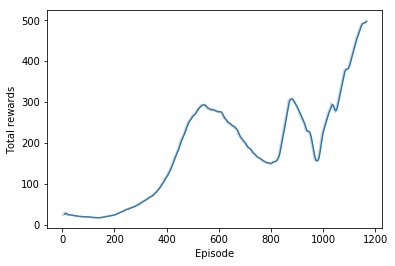

In [33]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

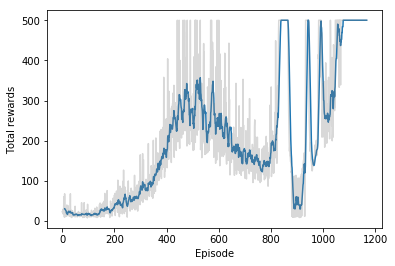

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Losses')

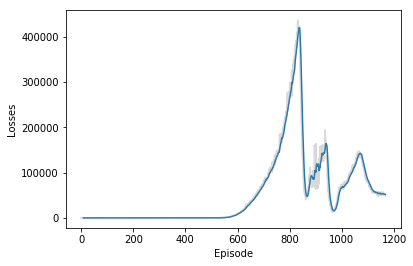

In [35]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            
            action = act(sess, state)
            
            state, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.